
# Семинар 8 - Алгоритмы анализа стереопар изображений

***

Полезные материалы:

- [First Principles of Computer Vision - Camera Calibration | Uncalibrated Stereo](https://youtube.com/playlist?list=PL2zRqk16wsdoCCLpou-dGo7QQNks1Ppzo&si=iXEBEehuQr-IgIVC) - плейлист с серией лекций по калибровке камеры и стереозрению
- [Simple Stereo | Camera Calibration](https://youtu.be/hUVyDabn1Mg?si=HmalQZKI9ytoyxPn) - лекция из плейлиста выше, в которой доступно раскрывается тема данного семинара

На этом семинаре будет разобрана тема стереозрения, которая заключается в применении нескольких видов камер для получения информации о глубине обзора. Используя стереозрение, можно определить местоположение точки в мире по ее изображениям в разных ракурсах камеры.

Термин охватывает многие приложения, работающие с несколькими видами отслеживаемого объекта под разными углами. Это могут быть стереокамеры, которые имеют несколько камер на одних и тех же устройствах, или разные виды с разных устройств.

1. **3D реконструкция с нескольких ракурсов**: знаем параметры калибровки каждой из камер, необходимо найти положение 3D объекта в мировых координатах.

2. **Оценка на основе движения (Structure From Motion)**: не знаем параметры калибровки, необходимо одновременно восстановить и координаты, и калибровку.

Первая задача проще в своей постановке, рассмотрим ее.

## Моно/Стерео зрение

_Источник изображений: https://github.com/polygon-software/python-visual-odometry_

![1_projection_and_stereo](data/1_projection_and_stereo.png)

**Идея:** можем найти пересечение лучей, исходящих из разных камер, и по параметрам камеры определить расстояние до объекта. Вы можете ощутить эффект стереовидения на основе своих глаз. Поставьте палец перед глазами. Закройте один глаз, потом другой глаз. Вы заметите, что пальцы, кажется, прыгают слева направо. Это наблюдаемое горизонтальное смещение называется диспаратностью (расхождением, disparity).

![3_stereo_cases](data/3_stereo_cases.png)

Рассмотрим более простой случай с выровненными (ректифицированными) камерами.

![4_stereo_vision_simple](data/4_stereo_vision_simple.png)

## Вопрос 1

Зная $f$ (фокальное расстояние камер), $b$ (расстояние между камерами), $u_l$, $u_r$, определить расстояние до объекта $Z_{p}$.

**Ответ:** $Z_p = (f * b) / (u_l - u_r)$

## Расчет диспаратности с помощью OpenCV

In [9]:
!wget https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_l.png -O data/tsukuba_l.png
!wget https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_r.png -O data/tsukuba_r.png

data/tsukuba_l.png: No such file or directory
data/tsukuba_r.png: No such file or directory


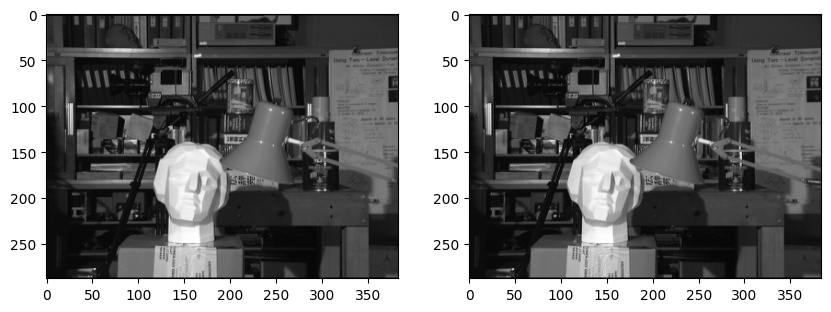

In [10]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

imgL = cv2.imread('/content/tsukuba_l.png',0)
imgR = cv2.imread('/content/tsukuba_r.png',0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(imgL, cmap="gray")
ax[1].imshow(imgR, cmap="gray")

### cv2.StereoBM_create

https://docs.opencv.org/4.5.0/d9/dba/classcv_1_1StereoBM.html#a04fdf00525f82fe708d556e2cd359004

Чем меньше `blockSize` - тем детальнее карта диспаратности, однако и количество шума растет.

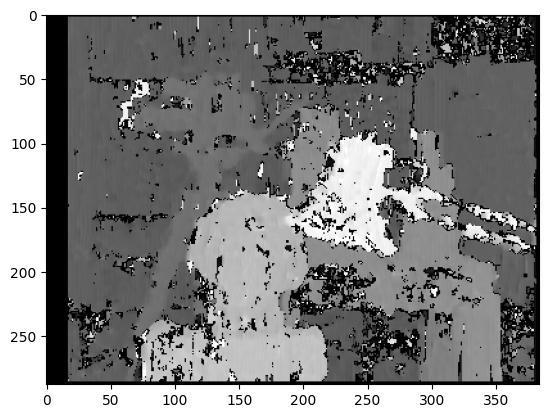

In [11]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=5,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray')

При слишком больших значениях `blockSize` шум отсутствует, однако детализация крайне низка:

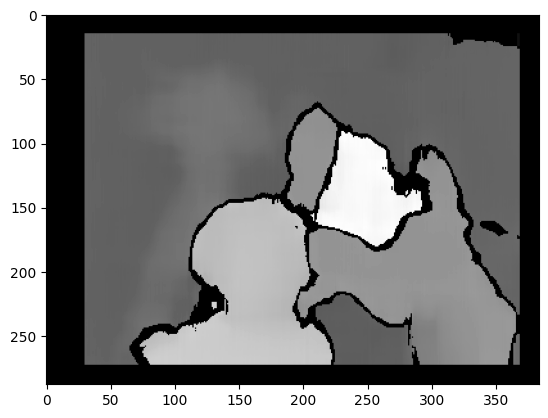

In [12]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=31,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray')

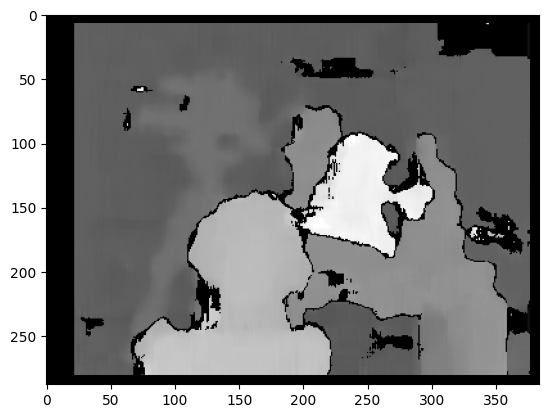

In [13]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=15,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray')

## Задание 1 - реализация алгоритма расчета диспаратности

Рассмотрим базовый жадный алгоритм наилучшего соответсвия (winner takes all, WTA) между изображениями с помощью блоков и метрики близости (sum of absolute difference, SAD).

![alg](data/alg.png)

**Заполните пропуски в коде**

In [29]:
def compare_blocks(
    block_left: np.array,
    block_right: np.array,
) -> float:
    '''
    Takes blocks from left/right image
    and return similarity metric (for example, sum of absolute differences)
    '''
    a = abs(block_left - block_right)

    return np.sum(a)


def get_disparity(
    imgL: np.array,  # (H, W) Grayscale
    imgR: np.array,  # (H, W) Grayscale
    numDisparities: int,  # the same in opencv
    blockSize: int,  # the same in opencv
) -> np.array:

    assert imgL.shape == imgR.shape, 'Images are not equal'

    H, W = imgL.shape
    disparity_map = np.zeros_like(imgL)  # (H, W)
    block_radius = blockSize // 2

    for i in range(block_radius, H - block_radius):
        for j in range(block_radius, W - block_radius):
            # define base block to compare
            # using blockSize and i, j

            block_left = imgL[i - block_radius:i + block_radius + 1,
                               j - block_radius:j + block_radius + 1]
            metrics = []

            for k in range(numDisparities):
                j_right = j - k

                if j_right < block_radius:
                    metrics.append(float('inf'))
                    continue

                # define secondary block to compare
                # using blockSize and i, j
                block_right = imgR[i - block_radius:i + block_radius + 1,
                                    j_right - block_radius:j_right + block_radius + 1]

                metrics.append(
                    compare_blocks(
                      block_left,
                      block_right
                    )
                )

            best_index = np.argmin(metrics)

            # convert index to disparity
            # and fill it in disparity_map
            disparity = np.argmin(metrics)
            disparity_map[i, j] = (disparity * 255) / (numDisparities - 1)

    return disparity_map

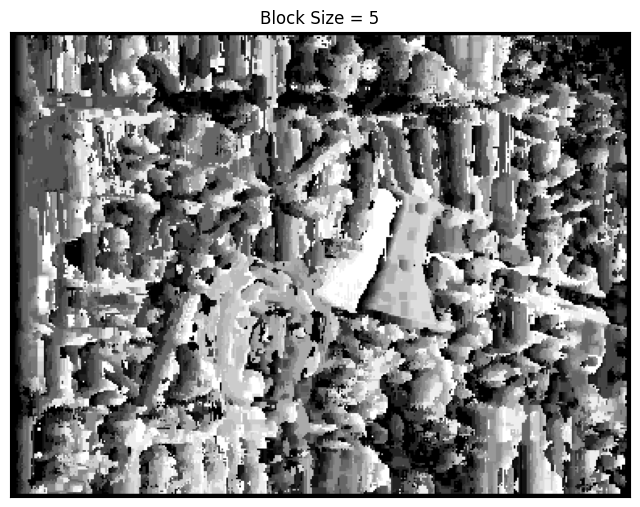

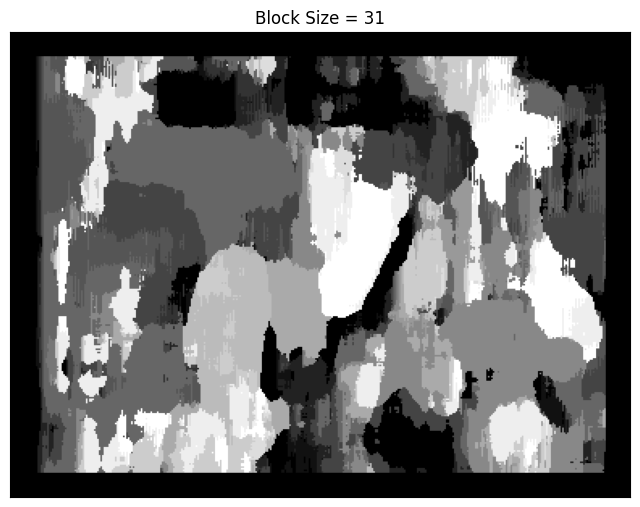

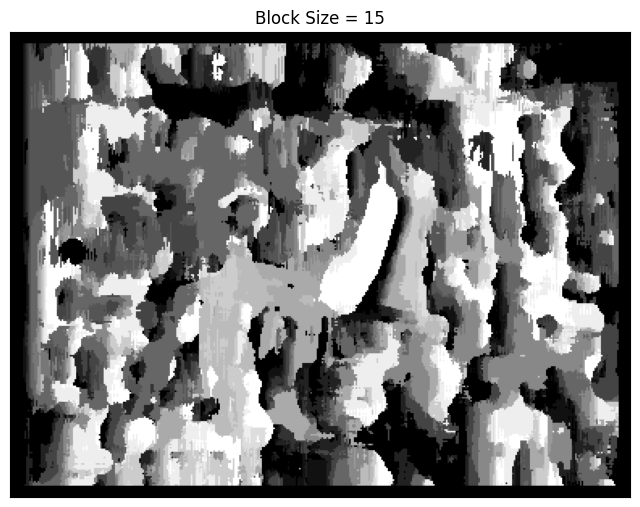

In [30]:
disparity_1 = get_disparity(
    imgL=imgL, imgR=imgR,
    numDisparities=16, blockSize=5
)
disparity_2 = get_disparity(
    imgL=imgL, imgR=imgR,
    numDisparities=16, blockSize=31
)
disparity_3 = get_disparity(
    imgL=imgL, imgR=imgR,
    numDisparities=16, blockSize=15
)

plt.figure(figsize=(8, 8))
plt.imshow(disparity_1, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block Size = 5")
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(disparity_2, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block Size = 31")
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(disparity_3, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title("Block Size = 15")
plt.show()

## Вопрос 2

Заполняет ли алгоритм все пиксели глубины? Как можно улучшить его? (Например, рассмотрите вариант, когда `metrics.min()` выдает большое число, что делать в этом случае? Или предложите свою версию.)

**Ответ:** Вообще говоря не совсем заполняет, но это и не гарантируется алгоритмом в сложных областях изображения.  
Способы улучшить:  

*   Методы постобработки для заполнения незаполненных или некорректно заполненных пикселей на карте диспаратности. Например, можно применить фильтрацию по соседним значениям или использовать алгоритмы интерполяции.  
*   Вместо фиксированного размера блока можно использовать адаптивный подход, где размер блока изменяется в зависимости от локальных характеристик изображения (например, изменение размера в областях с высокой детализацией).
*    На основе `metrics.min()`: если `metrics.min()` превышает определенный порог, это может означать, что соответствия для данного пикселя нет. В таком случае можно присвоить этому пикселю специальное значение (например, максимальную диспаратность) или значение, основанное на ближайших корректных диспаратностях.





## Задание 2

Сравните свою реализацию с opencv StereoBM с помощью попиксельного сравнения карт диспаратности.

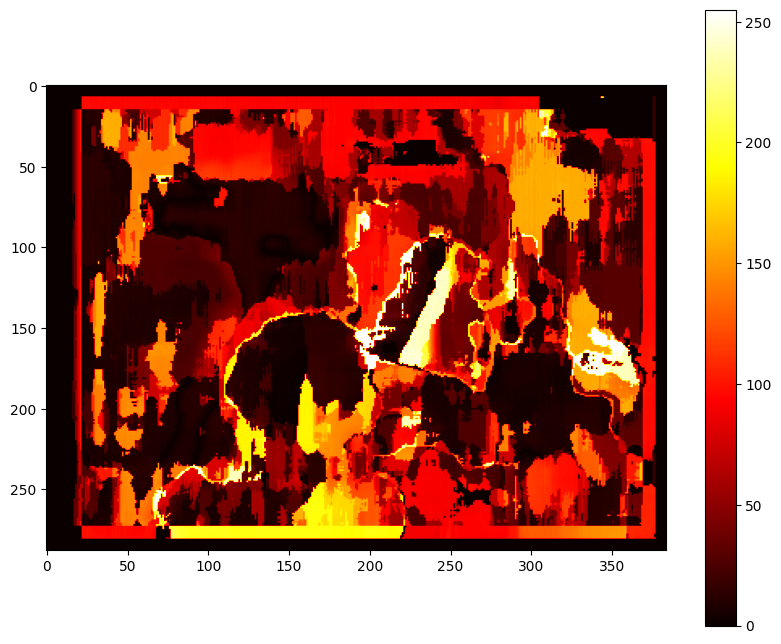

proportion: 0.8629828559027778


In [41]:
StereoBM = cv2.StereoBM_create(numDisparities=16, blockSize=31)
StereoBM = stereo.compute(imgL, imgR)
OpenCV_var = cv2.normalize(StereoBM, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
my_var = cv2.normalize(disparity_2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

plt.figure(figsize=(10, 8))
diff = np.abs(OpenCV_var - my_var)
plt.imshow(diff, cmap='hot')
plt.colorbar()
plt.show()
print(f'proportion: {1 - (np.sum(OpenCV_var == my_var) / np.sum(np.ones_like(OpenCV_var)))}')


## Вопрос 3

Как еще с помощью пройденных классических алгоритмов можно построить карту диспаратности? Приведите краткое описание придуманного/существующего алгоритма.

**Ответ:** Graph Cut Algorithm: Этот метод применяет графические модели для поиска наиболее вероятного распределения диспаратности. Он создает граф, в котором пиксели изображения представляют вершины, а возможные диспаратности - рёбра. Алгоритм находит минимальный разрез графа, который соответствует наилучшей карте диспаратности.